In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Load data
df = pd.read_csv('data/purchases.csv')

# Basic info
print("Dataset Shape:", df.shape)
print("\nColumn Types:")
print(df.dtypes)
print("\nFirst 5 rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (110194, 20)

Column Types:
transaction_id            object
customer_id               object
product_id                object
product_category_name     object
category                  object
product_price            float64
freight_value            float64
transaction_date          object
order_status              object
customer_city             object
customer_state            object
payment_type              object
payment_installments     float64
total_amount             float64
review_score             float64
review_count             float64
quantity                   int64
year                       int64
month                      int64
day_of_week               object
dtype: object

First 5 rows:
                     transaction_id                       customer_id  \
0  3b697a20d9e427646d92567910af6d57  32ea3bdedab835c3aa6cb68ce66565ef   
1  be5bc2f0da14d8071e2d45451ad119d9  2f64e403852e6893ae37485d5fcacdaf   
2  a41c8759fbe7aab36ea07e038b2d4465  61db744d2f83

In [3]:
# Convert date column
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Key Metrics
total_revenue = df['total_amount'].sum()
total_transactions = len(df)
unique_customers = df['customer_id'].nunique()
avg_order_value = df['total_amount'].mean()

print(f"""
📊 KEY METRICS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💰 Total Revenue: ${total_revenue:,.2f}
🛒 Total Transactions: {total_transactions:,}
👥 Unique Customers: {unique_customers:,}
💵 Average Order Value: ${avg_order_value:.2f}
""")


📊 KEY METRICS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💰 Total Revenue: $19,776,160.44
🛒 Total Transactions: 110,194
👥 Unique Customers: 93,357
💵 Average Order Value: $179.47



In [4]:

# 5.4 RFM ANALYSIS (Customer Segmentation)


from datetime import datetime

# Get most recent date in dataset
max_date = df['transaction_date'].max()
print(f"Analysis date (most recent order): {max_date.date()}")

# Calculate RFM metrics per customer
rfm = df.groupby('customer_id').agg({
    'transaction_date': lambda x: (max_date - x.max()).days,  # Recency
    'transaction_id': 'count',  # Frequency
    'total_amount': 'sum'  # Monetary
}).rename(columns={
    'transaction_date': 'recency',
    'transaction_id': 'frequency',
    'total_amount': 'monetary'
})

print("\n📊 RFM Statistics:")
print(rfm.describe())

# Create RFM scores (1-5, where 5 is best)
rfm['r_score'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1], duplicates='drop')
rfm['f_score'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
rfm['m_score'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5], duplicates='drop')

# Combine into single RFM score
rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)

print("\n🏆 Top 10 Customers by RFM Score:")
print(rfm.sort_values('rfm_score', ascending=False).head(10))

Analysis date (most recent order): 2018-08-29

📊 RFM Statistics:
            recency     frequency       monetary
count  93357.000000  93357.000000   93357.000000
mean     236.936673      1.180351     211.833718
std      152.584315      0.620832     642.166523
min        0.000000      1.000000       9.590000
25%      113.000000      1.000000      63.760000
50%      218.000000      1.000000     112.950000
75%      345.000000      1.000000     201.740000
max      694.000000     24.000000  109312.640000

🏆 Top 10 Customers by RFM Score:
                                  recency  frequency  monetary r_score  \
customer_id                                                              
edab6374fa7fcaa308f361598969b01d       26          1    264.69       5   
22e8b5bc5e81dfa4a832da8f0b1452da        5          2    238.48       5   
04971801420422ac37540eea29047f22       24          4   1078.08       5   
21ea6d29806d0ef7296ddf05e7b03491       83          2    240.88       5   
8e590b80243c5491

In [7]:
# ============================================
# 5.5 SEGMENT CUSTOMERS
# ============================================

def segment_customers(row):
    """Segment customers based on RFM scores"""
    score = int(row['r_score']) + int(row['f_score']) + int(row['m_score'])
    
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal Customers'
    elif score >= 7:
        return 'Potential Loyalists'
    elif score >= 5:
        return 'At Risk'
    else:
        return 'Lost Customers'

rfm['segment'] = rfm.apply(segment_customers, axis=1)

print("👥 Customer Segments Distribution:")
print(rfm['segment'].value_counts())
print("\n📊 Segment Statistics:")
print(rfm.groupby('segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean'
}).round(2))

# Save RFM analysis
rfm.to_csv('outputs/rfm_analysis.csv')
print("\n✅ Saved: outputs/rfm_analysis.csv")

👥 Customer Segments Distribution:
segment
Potential Loyalists    37483
Loyal Customers        29329
At Risk                13384
Champions               9687
Lost Customers          3474
Name: count, dtype: int64

📊 Segment Statistics:
                     recency  frequency  monetary
segment                                          
At Risk               354.03       1.00     71.16
Champions             105.55       1.95    578.38
Lost Customers        435.48       1.00     48.02
Loyal Customers       185.07       1.25    282.37
Potential Loyalists   251.26       1.01    127.33

✅ Saved: outputs/rfm_analysis.csv


In [8]:
# ============================================
# 5.6 PRODUCT PERFORMANCE ANALYSIS
# ============================================

# Top products by revenue
top_products = df.groupby('category').agg({
    'total_amount': 'sum',
    'quantity': 'sum',
    'transaction_id': 'count',
    'customer_id': 'nunique'
}).rename(columns={
    'transaction_id': 'order_count',
    'customer_id': 'unique_customers'
}).sort_values('total_amount', ascending=False)

print("🏆 Top 10 Categories by Revenue:")
print(top_products.head(10))

# Add average metrics
top_products['avg_order_value'] = top_products['total_amount'] / top_products['order_count']
top_products['items_per_order'] = top_products['quantity'] / top_products['order_count']

print("\n📦 Category Performance Metrics:")
print(top_products[['avg_order_value', 'items_per_order']].head(10).round(2))

🏆 Top 10 Categories by Revenue:
                       total_amount  quantity  order_count  unique_customers
category                                                                    
bed_bath_table           1692714.28     10953        10953              9008
health_beauty            1620684.04      9462         9462              8497
computers_accessories    1549372.59      7644         7644              6405
furniture_decor          1394466.93      8160         8160              6178
watches_gifts            1387362.45      5859         5859              5421
sports_leisure           1349446.93      8431         8431              7341
housewares               1069787.97      6795         6795              5681
auto                      833745.67      4140         4140              3769
garden_tools              810614.93      4268         4268              3420
cool_stuff                744649.32      3718         3718              3543

📦 Category Performance Metrics:
           

In [9]:
# ============================================
# 5.7 TEMPORAL TRENDS
# ============================================

# Add time columns
df['year_month'] = df['transaction_date'].dt.to_period('M')
df['day_of_week'] = df['transaction_date'].dt.day_name()
df['hour'] = df['transaction_date'].dt.hour

# Monthly trends
monthly = df.groupby('year_month').agg({
    'total_amount': 'sum',
    'transaction_id': 'count',
    'customer_id': 'nunique'
}).rename(columns={
    'transaction_id': 'orders',
    'customer_id': 'unique_customers'
})

monthly['avg_order_value'] = monthly['total_amount'] / monthly['orders']
monthly.index = monthly.index.astype(str)

print("📅 Monthly Performance:")
print(monthly.tail(6))

# Day of week pattern
dow_sales = df.groupby('day_of_week')['total_amount'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

print("\n📆 Sales by Day of Week:")
print(dow_sales)

📅 Monthly Performance:
            total_amount  orders  unique_customers  avg_order_value
year_month                                                         
2018-03       1435458.33    8017              6914       179.051806
2018-04       1466607.15    7827              6744       187.377942
2018-05       1480667.59    7810              6693       189.586119
2018-06       1285926.11    7010              6061       183.441670
2018-07       1307228.18    6963              6100       187.739219
2018-08       1211240.09    7142              6310       169.593964

📆 Sales by Day of Week:
day_of_week
Monday       3222464.57
Tuesday      3241134.22
Wednesday    3075201.51
Thursday     2998814.95
Friday       2939607.40
Saturday     2094454.99
Sunday       2204482.80
Name: total_amount, dtype: float64


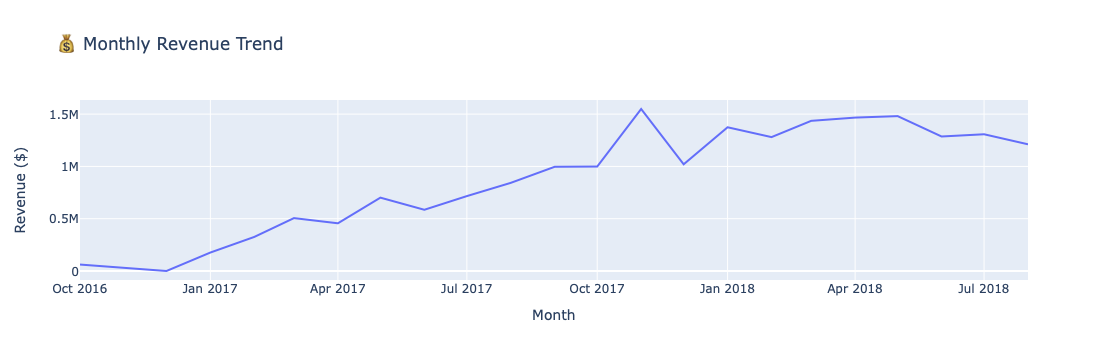

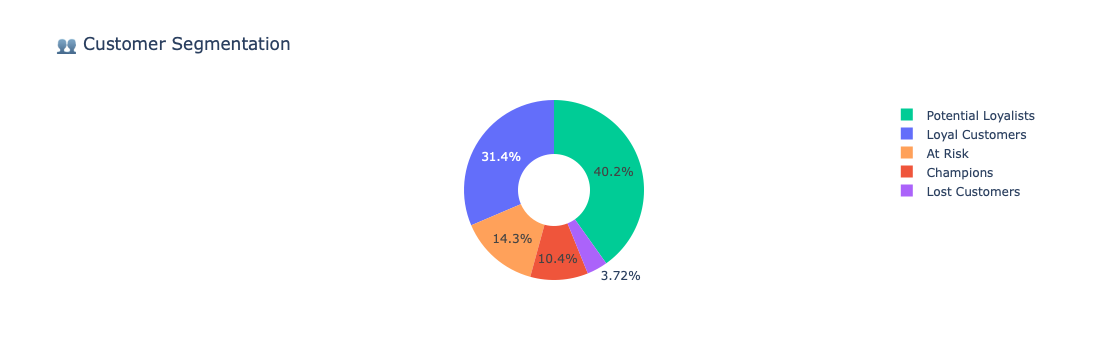

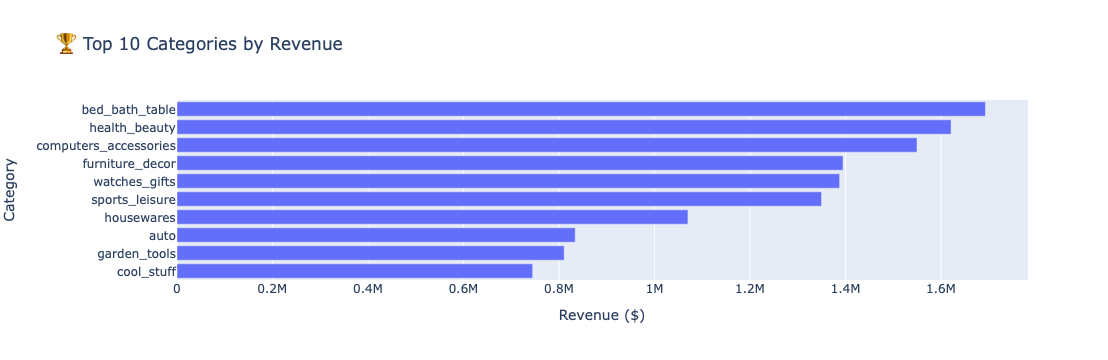

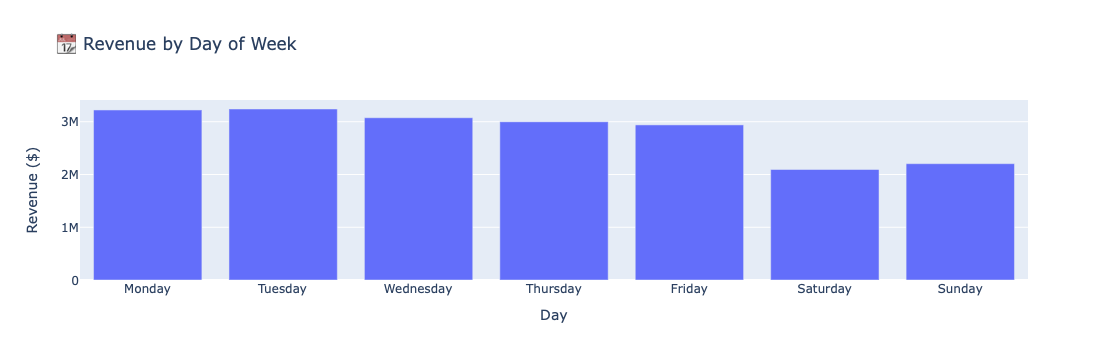

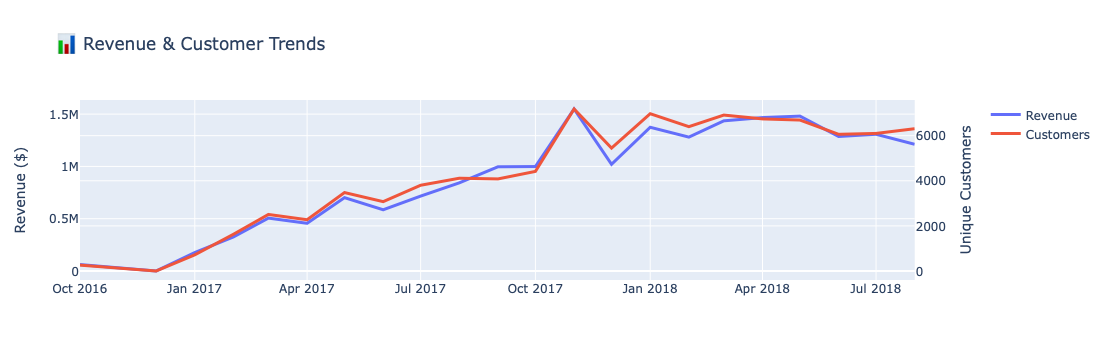

✅ All visualizations generated!


In [11]:
# ============================================
# 5.8 VISUALIZATIONS
# ============================================

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Revenue Trend
fig1 = px.line(monthly.reset_index(), 
               x='year_month', 
               y='total_amount',
               title='💰 Monthly Revenue Trend',
               labels={'total_amount': 'Revenue ($)', 'year_month': 'Month'})
fig1.show()

# 2. Customer Segments
segment_counts = rfm['segment'].value_counts()
colors = ['#00CC96', '#636EFA', '#FFA15A', '#EF553B', '#AB63FA']

fig2 = go.Figure(data=[go.Pie(
    labels=segment_counts.index,
    values=segment_counts.values,
    marker=dict(colors=colors),
    hole=0.4
)])
fig2.update_layout(title='👥 Customer Segmentation')
fig2.show()

# 3. Top Categories
fig3 = px.bar(top_products.head(10).reset_index(), 
              x='total_amount', 
              y='category',
              orientation='h',
              title='🏆 Top 10 Categories by Revenue',
              labels={'total_amount': 'Revenue ($)', 'category': 'Category'})
fig3.update_layout(yaxis={'categoryorder': 'total ascending'})
fig3.show()

# 4. Day of Week Pattern
fig4 = px.bar(dow_sales.reset_index(), 
              x='day_of_week', 
              y='total_amount',
              title='📆 Revenue by Day of Week',
              labels={'total_amount': 'Revenue ($)', 'day_of_week': 'Day'})
fig4.show()

# 5. Monthly Trends (Dual Axis)
fig5 = make_subplots(specs=[[{"secondary_y": True}]])

fig5.add_trace(
    go.Scatter(x=monthly.index, y=monthly['total_amount'], 
               name='Revenue', line=dict(color='#636EFA', width=3)),
    secondary_y=False
)

fig5.add_trace(
    go.Scatter(x=monthly.index, y=monthly['unique_customers'], 
               name='Customers', line=dict(color='#EF553B', width=3)),
    secondary_y=True
)

fig5.update_layout(title='📊 Revenue & Customer Trends', hovermode='x unified')
fig5.update_yaxes(title_text="Revenue ($)", secondary_y=False)
fig5.update_yaxes(title_text="Unique Customers", secondary_y=True)
fig5.show()

print("✅ All visualizations generated!")

In [12]:
# ============================================
# 5.9 PAYMENT & REVIEW INSIGHTS 
# ============================================

# Payment method analysis
if 'payment_type' in df.columns:
    payment_analysis = df.groupby('payment_type').agg({
        'total_amount': ['sum', 'mean', 'count'],
        'payment_installments': 'mean'
    }).round(2)
    
    print("💳 Payment Method Analysis:")
    print(payment_analysis)
    
    # Installments vs Order Value
    installment_groups = df.groupby('payment_installments')['total_amount'].agg(['mean', 'count'])
    print("\n📊 Installments vs Average Order Value:")
    print(installment_groups.head(10))

# Review score analysis
if 'review_score' in df.columns:
    review_analysis = df.groupby('category')['review_score'].agg(['mean', 'count']).sort_values('mean', ascending=False)
    
    print("\n⭐ Category Review Scores:")
    print(review_analysis.head(10))
    
    # Review vs Repeat Purchase
    customer_reviews = df.groupby('customer_id').agg({
        'review_score': 'mean',
        'transaction_id': 'count'
    }).rename(columns={'transaction_id': 'purchase_count'})
    
    print("\n🔁 Review Score vs Repeat Purchases:")
    print(customer_reviews.groupby('purchase_count')['review_score'].mean())

💳 Payment Method Analysis:
             total_amount                payment_installments
                      sum    mean  count                 mean
payment_type                                                 
boleto         3943080.78  176.33  22362                 1.00
credit_card   15211591.63  182.50  83351                 3.64
debit_card      246677.51  149.32   1652                 1.00
voucher         374810.52  132.49   2829                 1.00

📊 Installments vs Average Order Value:
                            mean  count
payment_installments                   
0.0                   106.190000      3
1.0                   142.830450  53158
2.0                   135.774799  13258
3.0                   154.830738  11379
4.0                   181.081305   7732
5.0                   197.784519   5847
6.0                   236.442035   4472
7.0                   194.072180   1752
8.0                   311.676076   4872
9.0                   204.279458    701

⭐ Category Review 

In [14]:
# ============================================
# 5.10 SAVE COMPREHENSIVE SUMMARY
# ============================================

# Create summary dictionary
summary_data = {
    'metrics': {
        'total_revenue': float(total_revenue),
        'total_transactions': int(total_transactions),
        'unique_customers': int(unique_customers),
        'avg_order_value': float(avg_order_value),
        'date_range': f"{df['transaction_date'].min().date()} to {df['transaction_date'].max().date()}"
    },
    'segments': rfm['segment'].value_counts().to_dict(),
    'top_categories': top_products.head(5)['total_amount'].to_dict(),
    'monthly_trend': monthly['total_amount'].to_dict()
}

# Save as JSON
import json
with open('outputs/analysis_summary.json', 'w') as f:
    json.dump(summary_data, f, indent=2, default=str)

print("✅ Saved: outputs/analysis_summary.json")
print("\n🎉 DATA EXPLORATION COMPLETE!")
print("=" * 50)
print("Next: Move to Day 2 - LLM Integration")

✅ Saved: outputs/analysis_summary.json

🎉 DATA EXPLORATION COMPLETE!
Next: Move to Day 2 - LLM Integration
